### Using SAM in combination with a pretrained Model trained for only detecting the text area

In [55]:
import os
import cv2
import sys
import onnx
import random

import torch
import numpy as np
import onnxruntime as ort
import torch.nn.functional as F
import matplotlib.pyplot as plt

from glob import glob
from typing import List, Dict
from natsort import natsorted
from IPython.display import Image as ShowImage
from PIL import Image

In [56]:
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 1024

In [57]:
def load_image(img_path: str) -> np.array:
    img = cv2.imread(img_path, 1)
    h, w, _ = img.shape
    img = cv2.resize(
        img,
        (
            IMAGE_WIDTH,
            IMAGE_HEIGHT
        ),
    )
    img = img.astype(np.float32)
    img /= 255.0
    img = np.expand_dims(img, axis=0)
    img = np.transpose(img, axes=[0, 3, 1, 2])
    return img

Images: 8


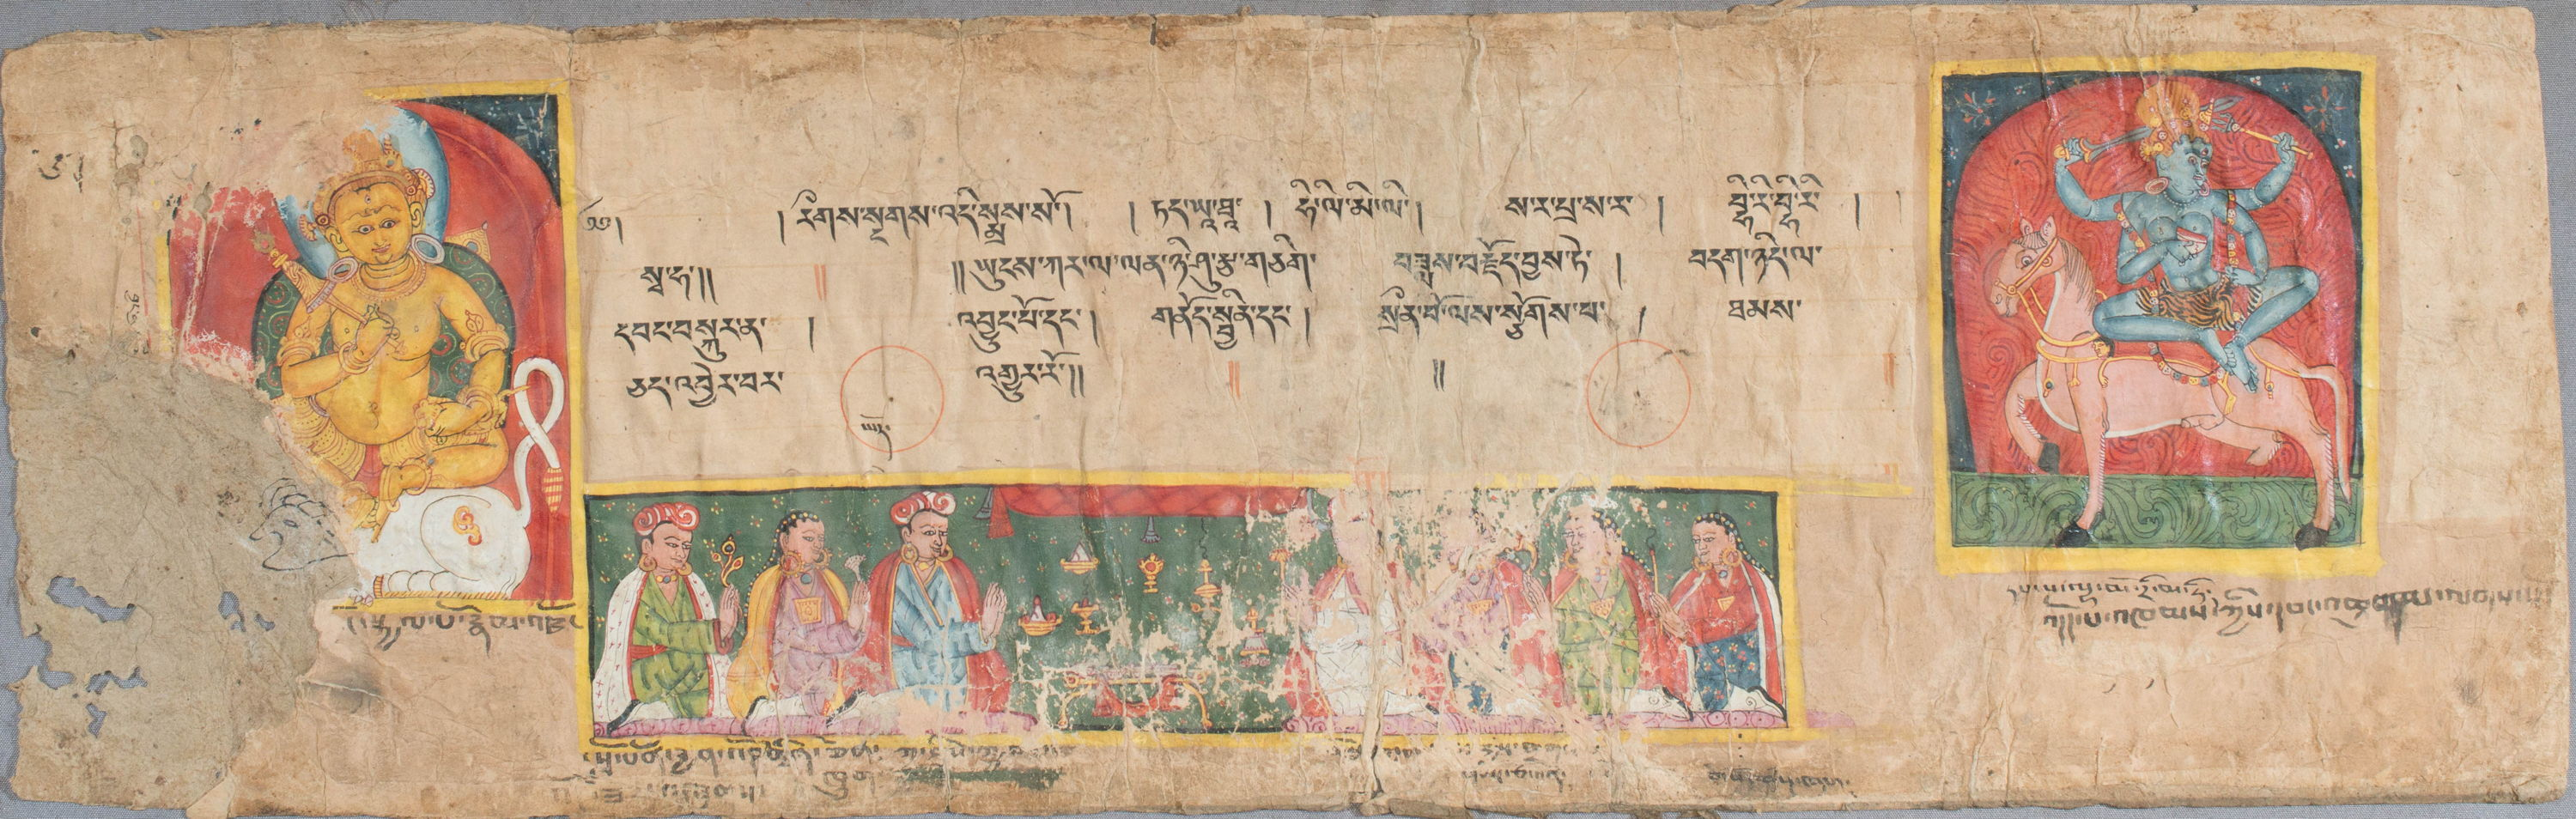

In [58]:
test_images = natsorted(glob("tmp/*.jpg"))
print(f"Images: {len(test_images)}")

rand_idx = random.randint(0, len(test_images))
ShowImage(test_images[rand_idx])

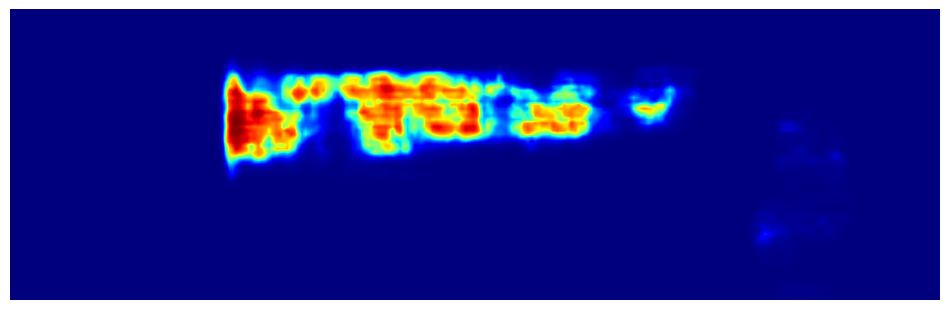

In [182]:
onnx_path = "OnnxModels\LA_TextArea_v1_quant.onnx"
ort_sess = ort.InferenceSession(onnx_path)

test_img = load_image(test_images[rand_idx])

outputs = ort_sess.run(None, {'input': test_img})
activated_outs = F.sigmoid(torch.from_numpy(outputs[0]))
activated_outs = torch.permute(activated_outs, dims=[0, 2, 3, 1])
activated_outs = torch.squeeze(activated_outs, dim=0)


plt.figure(figsize=(12, 4))
plt.axis('off')
plt.imshow(activated_outs, cmap="jet")

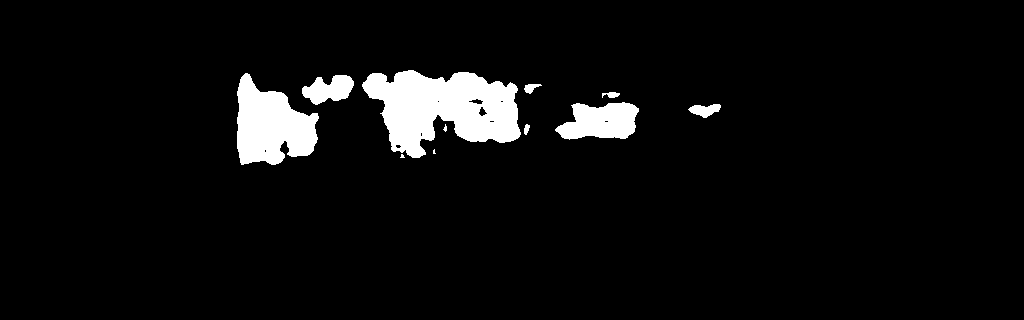

In [183]:
prob_threshold = 0.5
prediction = np.where(activated_outs > prob_threshold, 255, 0)
prediction = prediction.astype(np.uint8)
prediction = cv2.cvtColor(prediction, cv2.COLOR_GRAY2RGB)
display(Image.fromarray(prediction))

#### 1. Use BBox Centers from Predicted mask als InputPoints for SAM

In [184]:
from segment_anything import sam_model_registry, SamPredictor

In [185]:
img_mask = cv2.cvtColor(prediction, cv2.COLOR_RGB2GRAY)
contours, _ = cv2.findContours(img_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
areas = [cv2.contourArea(x) for x in contours]

def filter_areas(x):
    area_threshold = (IMAGE_HEIGHT * IMAGE_WIDTH) * 0.001
    area = cv2.contourArea(x)
    if area > area_threshold:
        return area 


filtered_contours = list(filter(filter_areas, contours))

print(f"Total Contours: {len(contours)}, Filtered Contours: {len(filtered_contours)}")

Total Contours: 20, Filtered Contours: 4


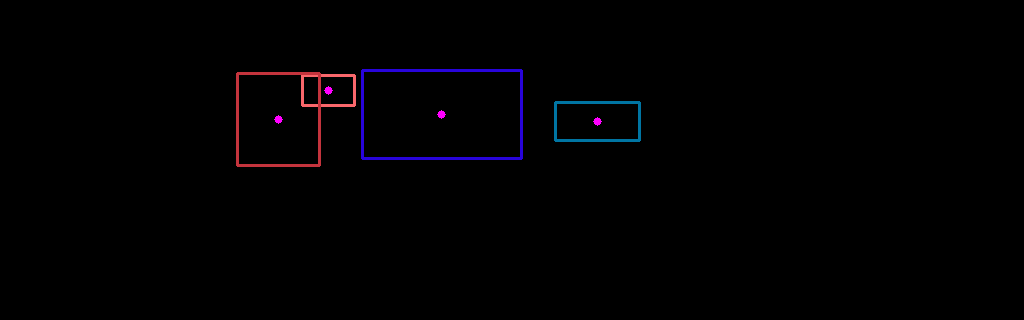

In [186]:
preview_bbox = np.zeros(shape=(prediction.shape), dtype=np.uint8)

input_points = []

for contour in filtered_contours:
    x,y,w,h = cv2.boundingRect(contour)
    
    center_point = [int(x+w/2), int(y+h/2)]
    input_points.append(center_point)
    
    random_color = [random.randint(0, 256) for x in range(3)]
    cv2.rectangle(preview_bbox,(x,y),(x+w,y+h), random_color, 2)
    cv2.circle(preview_bbox, center_point, radius=4, color=(255, 0, 255), thickness=-1)
    
display(Image.fromarray(preview_bbox))

In [187]:
input_points = np.array(input_points)
input_labels = np.ones(shape=(input_points.shape[0], ), dtype=np.uint8)

In [188]:
def init_sam(checkpoint: str, model_type: str) -> SamPredictor:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using device: {device}")
    
    sam = sam_model_registry[model_type](checkpoint=checkpoint)

    if device == "cuda":
        torch.cuda.empty_cache()
    sam.to(device)
    predictor = SamPredictor(sam)

    return predictor
    
    

In [189]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam_predictor = init_sam(sam_checkpoint, model_type)

using device: cuda


In [190]:
"""
- https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
"""

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

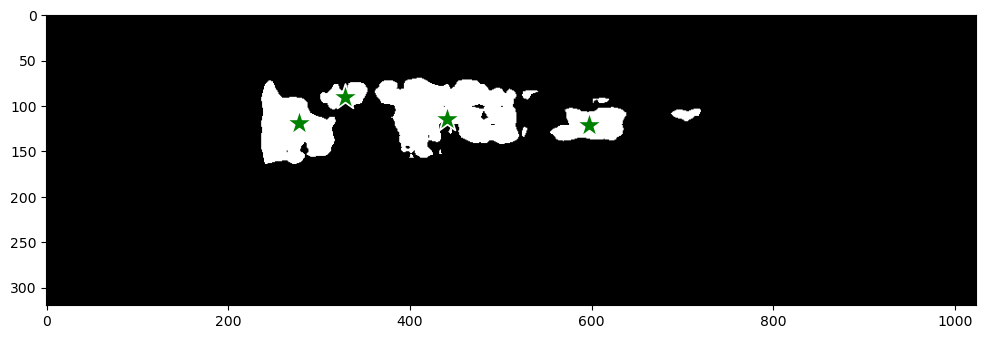

In [191]:
plt.figure(figsize=(12,4))
plt.imshow(prediction)
show_points(input_points, input_labels, plt.gca())
plt.axis('on')
plt.show()  

In [192]:
orig_image = cv2.imread(test_images[rand_idx])
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
orig_image = cv2.resize(orig_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

sam_predictor.set_image(orig_image)

# using just the bbox center points
masks, scores, logits = sam_predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,
)

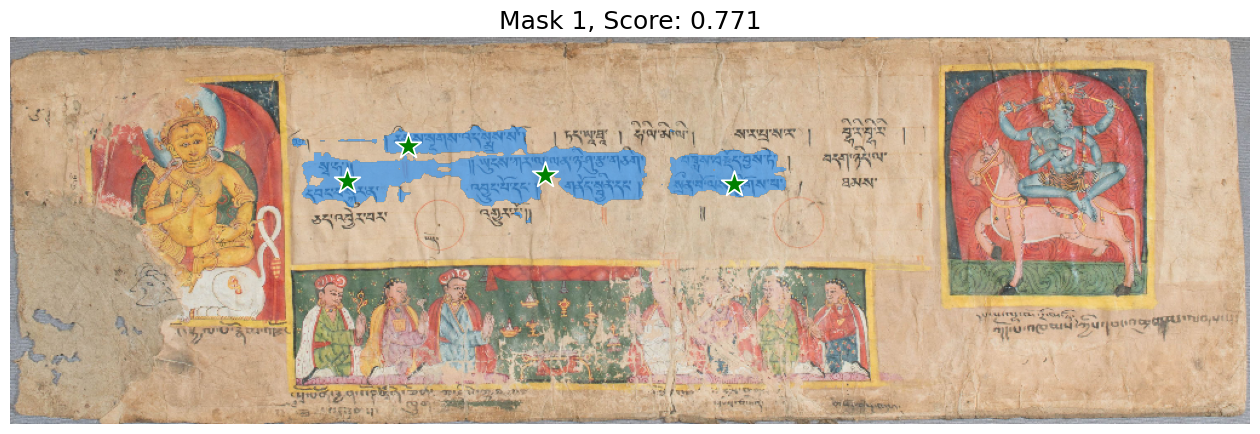

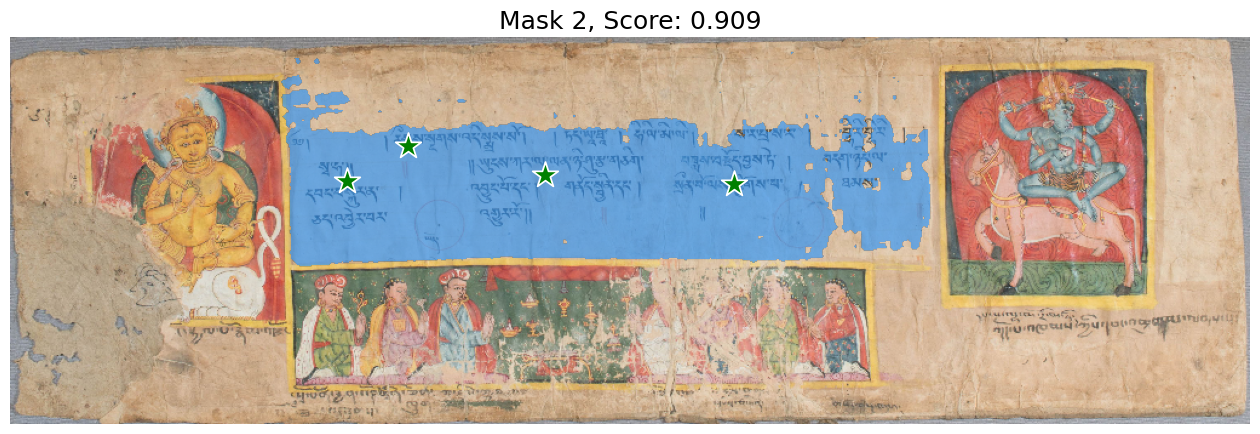

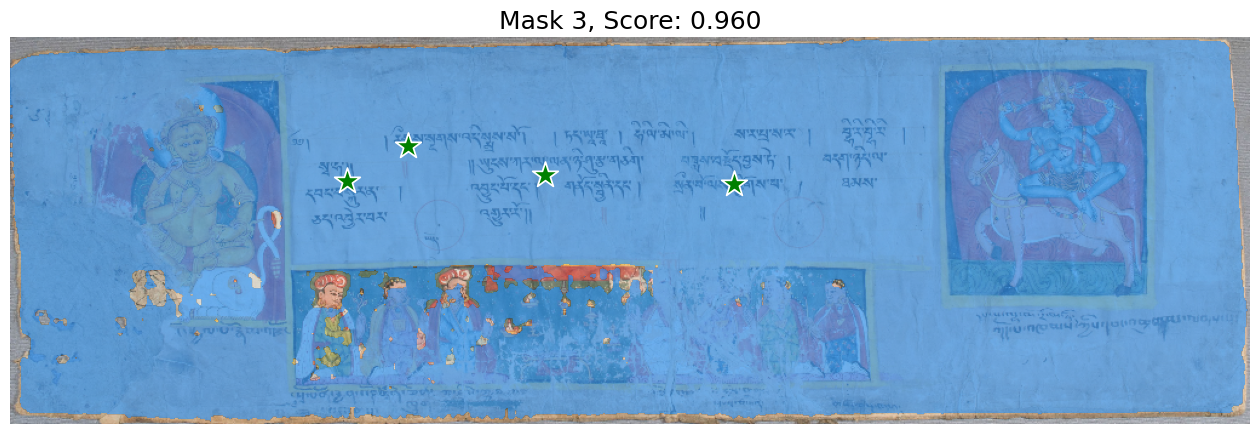

In [193]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(16,10))
    plt.imshow(orig_image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

#### 2. Use predicted mask from pretrained model in combination with guiding points

In [158]:

pred_mask = cv2.cvtColor(prediction, cv2.COLOR_RGB2GRAY)
pred_mask = cv2.resize(pred_mask, (256, 256)) # SAM needs this mask to be 256x256
pred_mask = np.expand_dims(pred_mask, axis=-1)
pred_mask = np.transpose(pred_mask, axes=[2, 0, 1])
print(pred_mask.shape)


(1, 256, 256)


In [175]:
masks, scores, logits = sam_predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    mask_input=pred_mask,
    multimask_output=True,
)

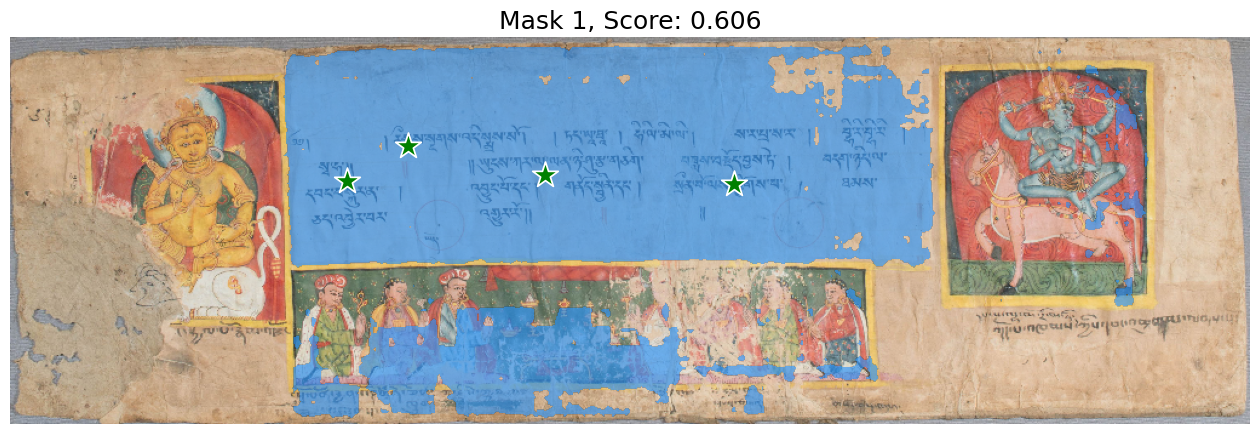

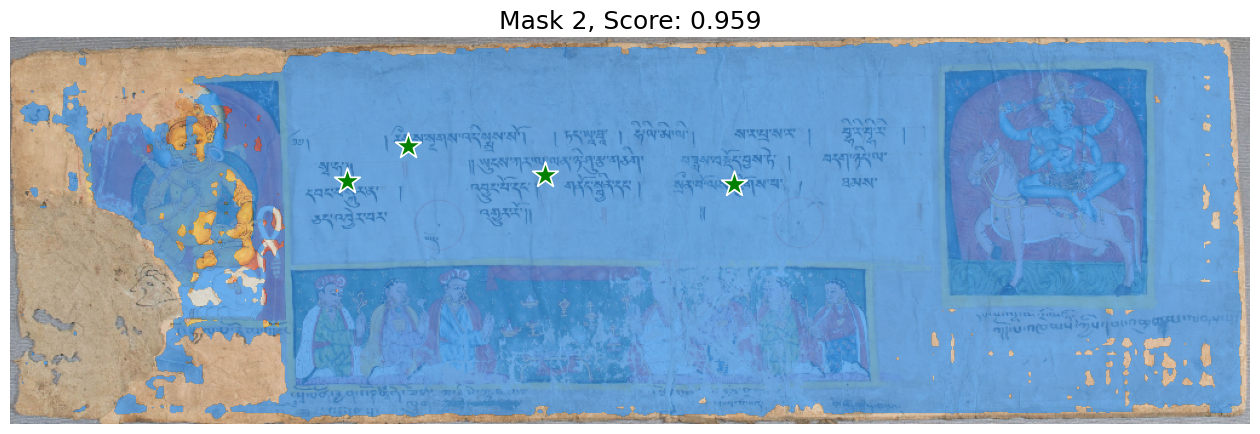

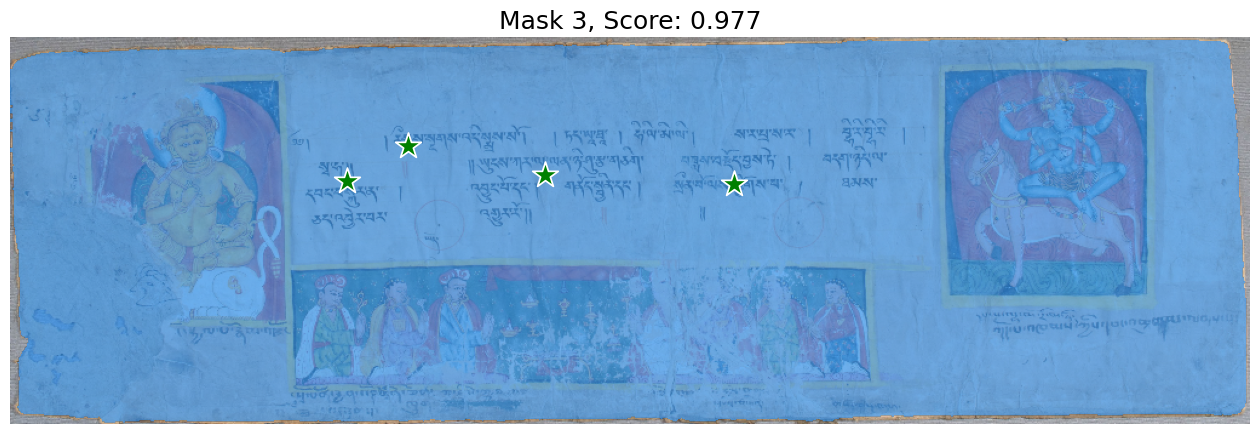

In [178]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(16,10))
    plt.imshow(orig_image)
    show_mask(mask, plt.gca())
    show_points(input_points, input_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  